In [39]:
# Imports and ensure dependencies are installed
import sys, subprocess
def ensure(pkg, name=None):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', name or pkg])

# install safe dependencies if missing
ensure('pandas')
ensure('numpy')
ensure('statsmodels')
ensure('scipy')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

print('pandas', pd.__version__, 'numpy', np.__version__)

pandas 2.3.2 numpy 2.3.4


In [40]:
def grs_test(returns, factors, risk_free_rate=None, intercept=True):
    """
    Gibbons, Ross, Shanken (1989) test for asset pricing model specification.
    
    Tests if all alphas (intercepts) are jointly zero across N test assets.
    
    Parameters
    ----------
    returns : pd.DataFrame or np.ndarray
        Shape (T, N). Excess returns of N test assets over T time periods.
        Can be DataFrame with asset returns as columns or (T, N) array.
    
    factors : pd.DataFrame or np.ndarray
        Shape (T, K). K risk factors over T time periods.
        Can be DataFrame with factors as columns or (T, K) array.
    
    risk_free_rate : pd.Series or np.ndarray, optional
        Shape (T,). Risk-free rate to compute excess returns.
        If provided, excess returns = returns - risk_free_rate.
        If None, assumes returns are already in excess form.
    
    intercept : bool, default True
        Whether to include intercept (alpha) in regression.
        Should be True for the standard GRS test.
    
    Returns
    -------
    dict
        Contains:
        - 'statistic': GRS F-statistic value
        - 'pvalue': p-value of the F-statistic
        - 'alphas': array of estimated alphas (intercepts)
        - 'residuals': (T, N) array of regression residuals
        - 'sigma_u': (N, N) covariance matrix of residuals
    
    Raises
    ------
    ValueError
        If inputs have incompatible shapes or insufficient observations.
    """
    
    returns = np.asarray(returns)
    factors = np.asarray(factors)
    
    T, N = returns.shape
    K = factors.shape[1] if factors.ndim > 1 else 1
    
    if factors.ndim == 1:
        factors = factors.reshape(-1, 1)
    
    if factors.shape[0] != T:
        raise ValueError(f"returns and factors must have same number of rows. Got {T} and {factors.shape[0]}")
    
    if T <= N + K:
        raise ValueError(f"Insufficient observations: need T > N + K, got T={T}, N={N}, K={K}")
    
    if risk_free_rate is not None:
        risk_free_rate = np.asarray(risk_free_rate).reshape(-1)
        if len(risk_free_rate) != T:
            raise ValueError(f"risk_free_rate length {len(risk_free_rate)} != T={T}")
        returns = returns - risk_free_rate.reshape(-1, 1)
    
    if np.isnan(returns).any() or np.isnan(factors).any():
        raise ValueError("Missing values (NaN) detected in returns or factors")
    
    X = factors.copy()
    if intercept:
        X = np.column_stack([np.ones(T), X])
    
    alphas = np.zeros(N)
    residuals = np.zeros((T, N))
    
    for i in range(N):
        y = returns[:, i]
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        residuals[:, i] = y - X @ beta
        if intercept:
            alphas[i] = beta[0]
    
    sigma_u = (residuals.T @ residuals) / T
    sigma_u_inv = np.linalg.inv(sigma_u)
    mean_factor = factors.mean(axis=0)
    
    if intercept:
        cov_factor = np.cov(factors.T)
        V = np.eye(1 + K)
        V[1:, 1:] = cov_factor
        V[1:, 0] = mean_factor
        V[0, 1:] = mean_factor
    else:
        V = np.cov(factors.T)
    
    V_inv = np.linalg.inv(V)
    
    if intercept:
        grs_stat = (T - N - K) / N * alphas @ sigma_u_inv @ alphas
    else:
        grs_stat = T / N * alphas @ sigma_u_inv @ alphas
    
    pvalue = 1 - stats.f.cdf(grs_stat, N, T - N - K)
    
    return {
        'statistic': grs_stat,
        'pvalue': pvalue,
        'alphas': alphas,
        'residuals': residuals,
        'sigma_u': sigma_u
    }

In [41]:
ensure('matplotlib')
ensure('seaborn')

import matplotlib.pyplot as plt
import seaborn as sns

def run_grs_analysis(returns_df, factors_df, risk_free_rate=None, test_name=""):
    """
    Run GRS test and return formatted results with diagnostics.
    
    Parameters
    ----------
    returns_df : pd.DataFrame
        Asset returns (T, N). Index should be dates, columns should be asset names.
    
    factors_df : pd.DataFrame
        Risk factors (T, K). Index should match returns_df.
    
    risk_free_rate : pd.Series, optional
        Risk-free rate aligned with indices.
    
    test_name : str, optional
        Description of the test (e.g., regime name).
    
    Returns
    -------
    dict
        GRS results with formatted summary.
    """
    
    returns_aligned = returns_df.copy()
    factors_aligned = factors_df.copy()
    
    if risk_free_rate is not None:
        rf_aligned = risk_free_rate.copy()
        common_idx = returns_aligned.index.intersection(factors_aligned.index).intersection(rf_aligned.index)
        returns_aligned = returns_aligned.loc[common_idx]
        factors_aligned = factors_aligned.loc[common_idx]
        rf_aligned = rf_aligned.loc[common_idx]
    else:
        common_idx = returns_aligned.index.intersection(factors_aligned.index)
        returns_aligned = returns_aligned.loc[common_idx]
        factors_aligned = factors_aligned.loc[common_idx]
        rf_aligned = None
    
    result = grs_test(returns_aligned.values, factors_aligned.values, 
                     risk_free_rate=rf_aligned.values if rf_aligned is not None else None)
    
    result['returns_df'] = returns_aligned
    result['factors_df'] = factors_aligned
    result['asset_names'] = returns_aligned.columns.tolist()
    result['factor_names'] = factors_aligned.columns.tolist()
    result['test_name'] = test_name
    result['dates'] = returns_aligned.index
    
    print(f"\n{'='*70}")
    print(f"GRS TEST RESULTS: {test_name}")
    print(f"{'='*70}")
    print(f"Observations (T): {returns_aligned.shape[0]}")
    print(f"Test Assets (N): {returns_aligned.shape[1]}")
    print(f"Risk Factors (K): {factors_aligned.shape[1]}")
    print(f"\nGRS Statistic: {result['statistic']:.6f}")
    print(f"P-value: {result['pvalue']:.6f}")
    
    if result['pvalue'] < 0.05:
        print("✗ REJECT H0: Model appears mis-specified (alphas jointly significant)")
    else:
        print("✓ FAIL TO REJECT H0: Model appears well-specified (alphas jointly zero)")
    
    print(f"\nAlphas (Intercepts):")
    for asset, alpha in zip(result['asset_names'], result['alphas']):
        print(f"  {asset:20s}: {alpha:10.6f}")
    
    return result


def plot_grs_diagnostics(grs_result, figsize=(14, 10)):
    """
    Generate comprehensive diagnostic plots for GRS test results.
    
    Parameters
    ----------
    grs_result : dict
        Output from run_grs_analysis().
    
    figsize : tuple
        Figure size (width, height).
    """
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    alphas = grs_result['alphas']
    residuals = grs_result['residuals']
    asset_names = grs_result['asset_names']
    test_name = grs_result['test_name']
    
    # 1. Alpha values
    ax1 = fig.add_subplot(gs[0, 0])
    colors = ['green' if a > 0 else 'red' for a in alphas]
    ax1.barh(asset_names, alphas, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.axvline(0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Alpha (Intercept)', fontsize=11, fontweight='bold')
    ax1.set_title('Estimated Alphas by Asset', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. GRS test statistic and p-value
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    
    stat_text = f"""
    GRS Test Summary: {test_name}
    
    Test Statistic: {grs_result['statistic']:.4f}
    P-value: {grs_result['pvalue']:.6f}
    
    Observations: {residuals.shape[0]}
    Assets: {residuals.shape[1]}
    
    Null Hypothesis (H₀):
    All alphas are jointly zero
    
    Result:
    {'Reject H₀ (p < 0.05)' if grs_result['pvalue'] < 0.05 else 'Fail to reject H₀ (p ≥ 0.05)'}
    """
    
    ax2.text(0.1, 0.5, stat_text, fontsize=11, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', 
            facecolor='wheat', alpha=0.5))
    
    # 3. Residuals over time
    ax3 = fig.add_subplot(gs[1, :])
    for i, name in enumerate(asset_names):
        ax3.plot(grs_result['dates'], residuals[:, i], label=name, alpha=0.7, linewidth=1.5)
    ax3.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Residual', fontsize=11, fontweight='bold')
    ax3.set_title('Regression Residuals Over Time', fontsize=12, fontweight='bold')
    ax3.legend(loc='best', ncol=min(4, len(asset_names)), fontsize=9)
    ax3.grid(alpha=0.3)
    
    # 4. Residuals distribution
    ax4 = fig.add_subplot(gs[2, 0])
    for i, name in enumerate(asset_names):
        ax4.hist(residuals[:, i], bins=20, alpha=0.5, label=name, edgecolor='black')
    ax4.set_xlabel('Residual Value', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax4.set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3, axis='y')
    
    # 5. Residual covariance heatmap
    ax5 = fig.add_subplot(gs[2, 1])
    cov_matrix = grs_result['sigma_u']
    sns.heatmap(cov_matrix, annot=True, fmt='.4f', cmap='coolwarm', center=0,
               xticklabels=asset_names, yticklabels=asset_names, ax=ax5,
               cbar_kws={'label': 'Covariance'})
    ax5.set_title('Residual Covariance Matrix', fontsize=12, fontweight='bold')
    
    plt.suptitle(f'GRS Test Diagnostics: {test_name}', fontsize=14, fontweight='bold', y=0.995)
    
    return fig


def compare_grs_results(results_dict, figsize=(12, 6)):
    """
    Compare GRS statistics across multiple regimes or models.
    
    Parameters
    ----------
    results_dict : dict
        Keys are test names, values are GRS result dicts from run_grs_analysis().
    
    figsize : tuple
        Figure size (width, height).
    """
    
    test_names = list(results_dict.keys())
    statistics = [results_dict[name]['statistic'] for name in test_names]
    pvalues = [results_dict[name]['pvalue'] for name in test_names]
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # GRS statistics
    colors_stat = ['green' if p >= 0.05 else 'red' for p in pvalues]
    axes[0].barh(test_names, statistics, color=colors_stat, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('GRS Statistic', fontsize=11, fontweight='bold')
    axes[0].set_title('GRS Test Statistic Comparison', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # P-values
    sig_level = 0.05
    axes[1].barh(test_names, pvalues, color=colors_stat, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1].axvline(sig_level, color='red', linestyle='--', linewidth=2, label=f'α = {sig_level}')
    axes[1].set_xlabel('P-value', fontsize=11, fontweight='bold')
    axes[1].set_title('P-value Comparison', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].set_xlim(0, max(pvalues) * 1.1)
    
    plt.tight_layout()
    
    return fig


print("✓ GRS test utilities loaded")

✓ GRS test utilities loaded


# GRS Test Runner Examples

This section demonstrates how to apply the GRS test to your factor model across different regimes.

In [42]:
regime_data = {}
regime_names = ['expansion', 'recession', 'crisis']

for regime in regime_names:
    try:
        df = pd.read_csv(f'data/{regime}_stock_signals.csv', parse_dates=['date'], index_col='date')
        df.index = df.index + pd.offsets.MonthEnd(0)
        regime_data[regime] = df
        print(f"✓ Loaded {regime}: {df.shape}")
    except FileNotFoundError:
        print(f"✗ {regime}_stock_signals.csv not found in data/")
    except Exception as e:
        print(f"✗ Error loading {regime}: {str(e)[:60]}")

/var/folders/5h/7gyshb790f549lhn9zp_6x380000gn/T/ipykernel_44924/161093845.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'data/{regime}_stock_signals.csv', parse_dates=['date'], index_col='date')


✓ Loaded expansion: (392567, 56)


/var/folders/5h/7gyshb790f549lhn9zp_6x380000gn/T/ipykernel_44924/161093845.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'data/{regime}_stock_signals.csv', parse_dates=['date'], index_col='date')


✓ Loaded recession: (279377, 56)
✓ Loaded crisis: (45675, 56)


/var/folders/5h/7gyshb790f549lhn9zp_6x380000gn/T/ipykernel_44924/161093845.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'data/{regime}_stock_signals.csv', parse_dates=['date'], index_col='date')


In [36]:
if regime_data:
    key_anomalies = ['size', 'value', 'prof', 'mom', 'ivol', 'lev', 'ep', 'roa']

    
    anomalies_available = [col for col in key_anomalies if col in regime_data[list(regime_data.keys())[0]].columns]
    
    grs_results_by_regime = {}
    
    for regime, df in regime_data.items():
        if 're' not in df.columns:
            print(f"✗ 're' (returns) column not found in {regime} data")
            continue
        
        returns_subset = df[['re']].copy()
        factors_subset = df[anomalies_available].copy()
        
        valid_idx = returns_subset.notna().all(axis=1) & factors_subset.notna().all(axis=1)
        returns_subset = returns_subset[valid_idx]
        factors_subset = factors_subset[valid_idx]
        
        if len(returns_subset) < 50:
            print(f"⚠ Skipping {regime}: insufficient observations ({len(returns_subset)} < 50)")
            continue
        
        try:
            grs_result = run_grs_analysis(
                returns_subset,
                factors_subset,
                risk_free_rate=None,
                test_name=regime.capitalize()
            )
            grs_results_by_regime[regime.capitalize()] = grs_result
        except Exception as e:
            print(f"✗ GRS test failed for {regime}: {str(e)[:80]}")


GRS TEST RESULTS: Expansion
Observations (T): 258780
Test Assets (N): 1
Risk Factors (K): 8

GRS Statistic: 2207.397834
P-value: 0.000000
✗ REJECT H0: Model appears mis-specified (alphas jointly significant)

Alphas (Intercepts):
  re                  :   0.008988

GRS TEST RESULTS: Recession
Observations (T): 189048
Test Assets (N): 1
Risk Factors (K): 8

GRS Statistic: 579.075552
P-value: 0.000000
✗ REJECT H0: Model appears mis-specified (alphas jointly significant)

Alphas (Intercepts):
  re                  :   0.005451

GRS TEST RESULTS: Crisis
Observations (T): 31155
Test Assets (N): 1
Risk Factors (K): 8

GRS Statistic: 55.242483
P-value: 0.000000
✗ REJECT H0: Model appears mis-specified (alphas jointly significant)

Alphas (Intercepts):
  re                  :   0.005283


## Regime-Based GRS Analysis

Test the model specification separately for each economic regime (expansion, recession, crisis).

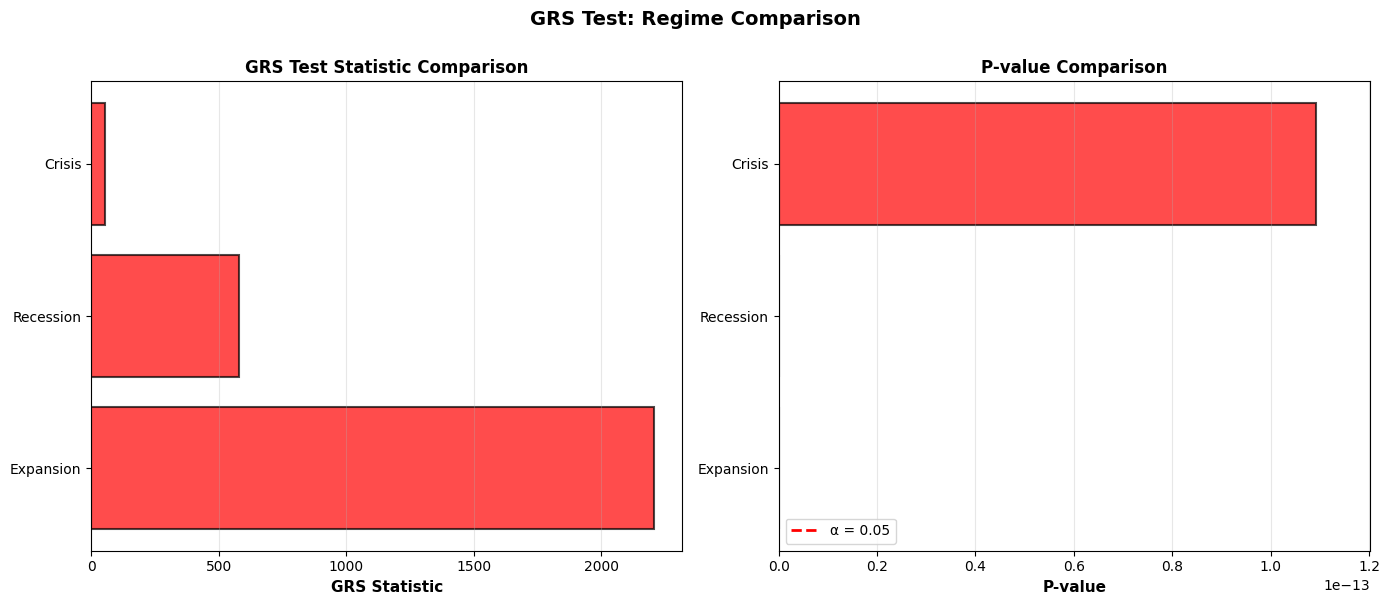

In [37]:
if grs_results_by_regime:
    fig = compare_grs_results(grs_results_by_regime, figsize=(14, 6))
    plt.suptitle('GRS Test: Regime Comparison', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

/var/folders/5h/7gyshb790f549lhn9zp_6x380000gn/T/ipykernel_44924/1847601234.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


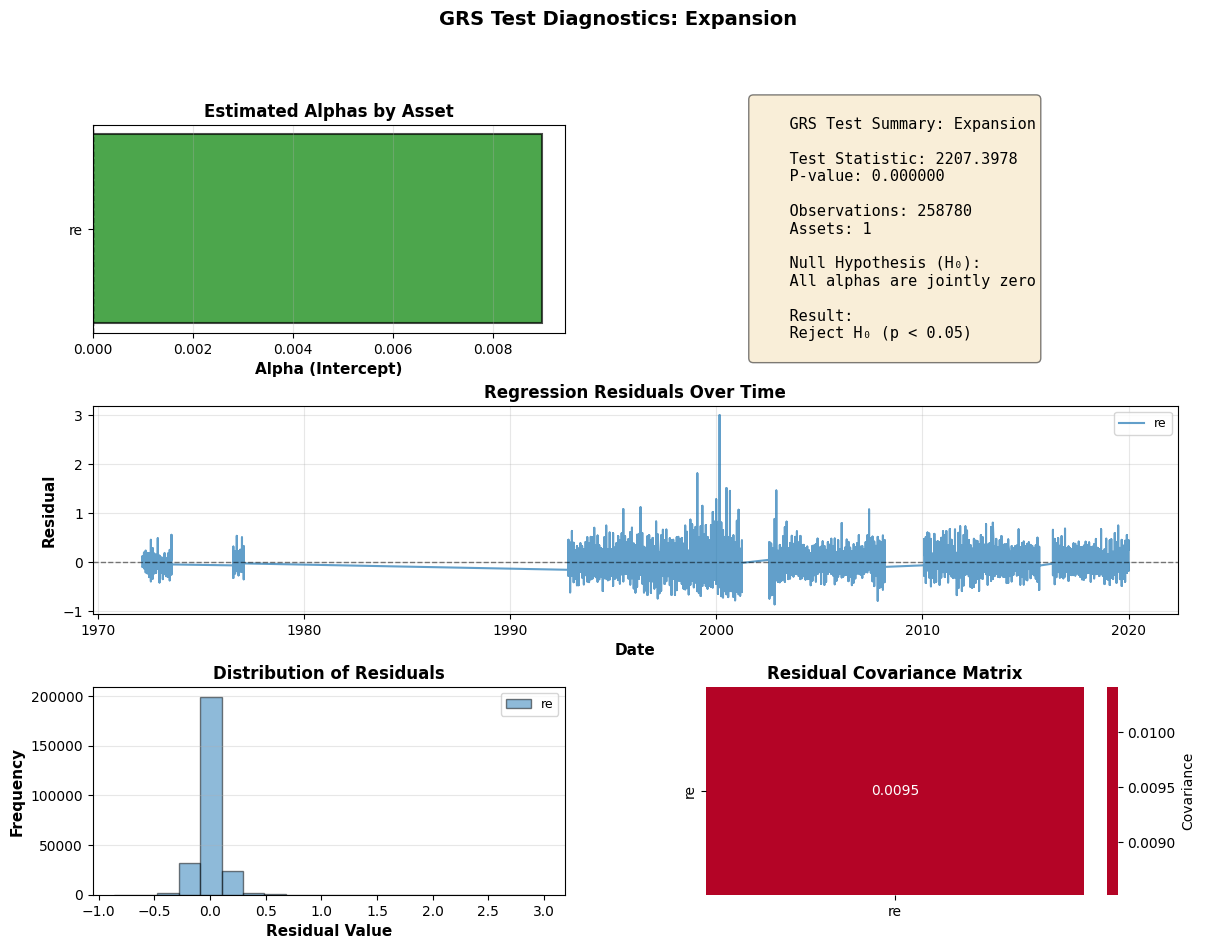

/var/folders/5h/7gyshb790f549lhn9zp_6x380000gn/T/ipykernel_44924/1847601234.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


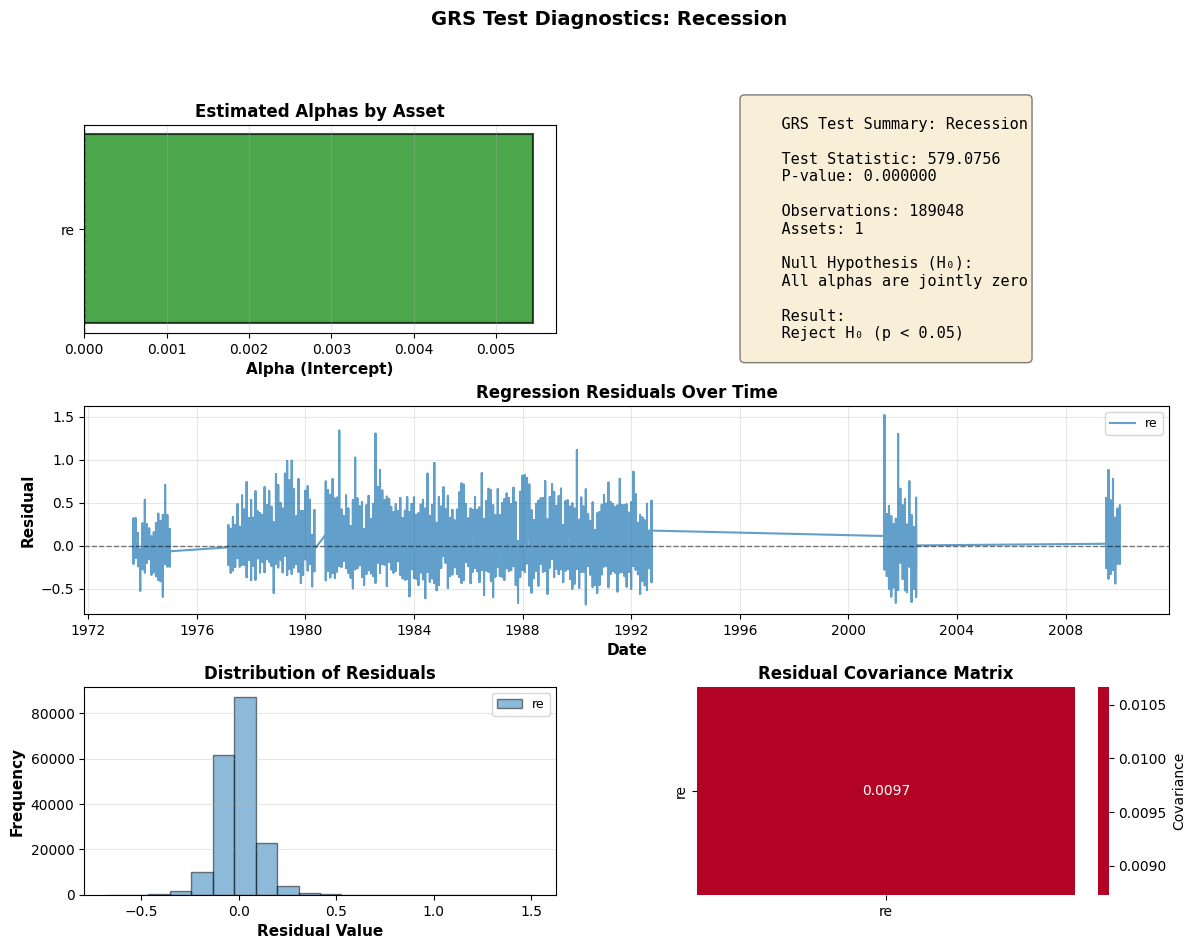

/var/folders/5h/7gyshb790f549lhn9zp_6x380000gn/T/ipykernel_44924/1847601234.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


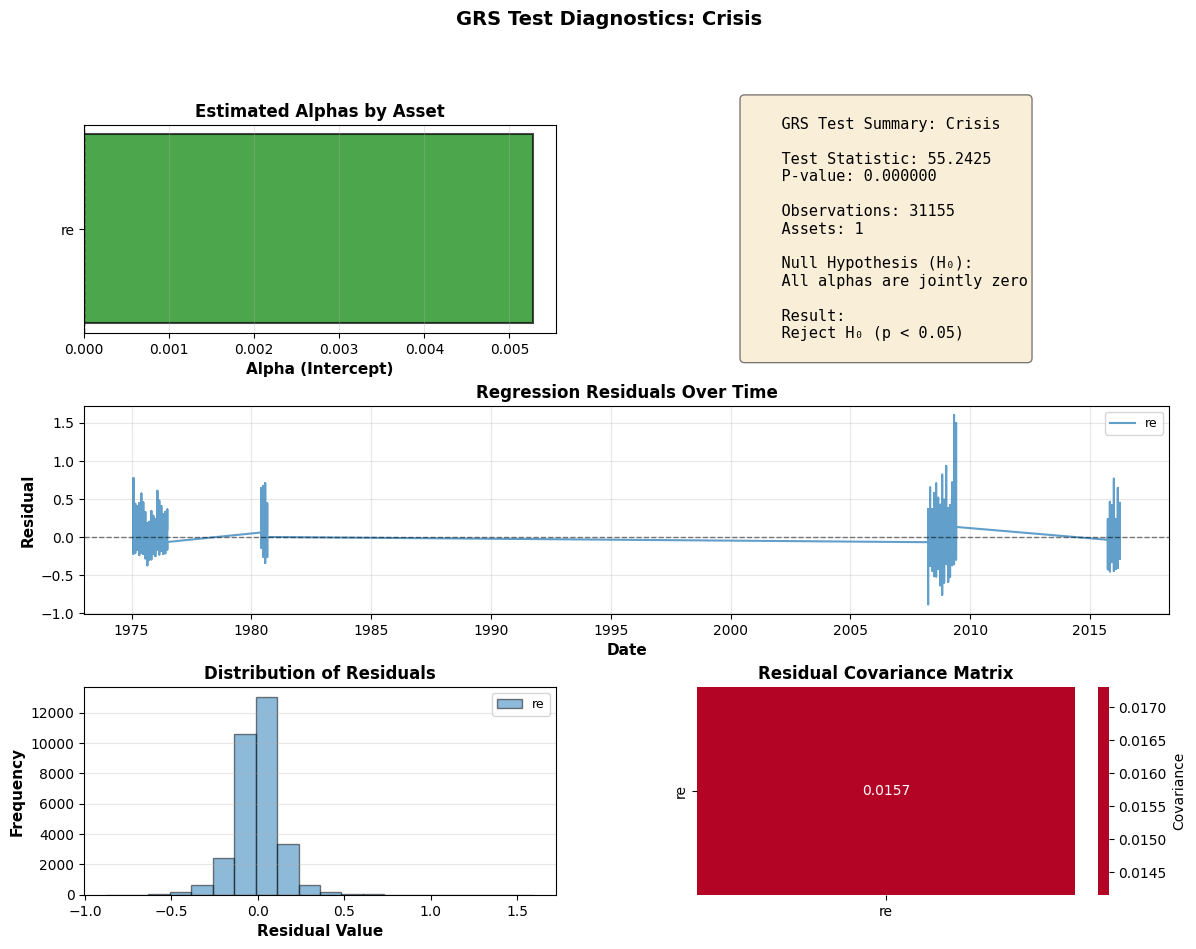

In [38]:
if grs_results_by_regime:
    for regime, result in grs_results_by_regime.items():
        fig = plot_grs_diagnostics(result, figsize=(14, 10))
        plt.tight_layout()
        plt.show()